In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import torch
from tqdm import tqdm
from datetime import datetime
from louvain import get_topic_vec, get_matching_score
# from cosine import get_word_set, get_cosine
from sklearn.metrics.pairwise import cosine_similarity
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

update_window = 5

- allocate words in smaller topics into larger ones based on some criteria (defensable)


In [2]:
# from collections import Counter
# for result in res['membership']:
#     print(sum([i >= 10 for i in Counter(result[0]).values()]))

In [3]:
# global topic
m = pd.read_csv("/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/cosine/cosine.csv", 
                 header=0, index_col=0)
num_words = len(m.columns)
assert num_words == 441

df_global = pd.read_csv('clustering_C_mod.csv')
temp = (1 - df_global.pivot_table(index='word', columns='Topic').isna().loc[m.columns]).values.T
membership_global = (df_global.set_index('word').loc[m.columns]['Topic'] - 1).to_list()
n_topics_global = max(membership_global)+1

arr = np.where(temp == 1)
clusters_global = [arr[1][np.where(arr[0] == i)] for i in range(n_topics_global)]

dtmPath = '/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/concat/dtm_concatenate.npz'
dtm_global = sparse.load_npz(dtmPath)
weights_global = np.array(dtm_global.sum(axis=0)/dtm_global.sum())[0]
word2weight_global = {k: v for k, v in zip(m.columns, weights_global)}
topic_vec_global = [get_topic_vec(cluster, m.columns.values, word2weight_global) for cluster in clusters_global]

In [4]:
def save_clustering_C(df_global, freq_sum, membership, output_dir):
    assert freq_sum.shape[0] == 441
    df = df_global.copy()
    df['freq'] = freq_sum
    df['Topic'] = np.array(membership_rolling) + 1
    df = df.sort_values(['Topic', 'freq'], ascending=[True, False])
    df.to_csv(output_dir, index=False)

In [5]:
rollingTopicPath = '/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/article_measure/rolling_topic'
pathinTopic = glob(rollingTopicPath + '/res_*_*.pt')
pathinTopic.sort()

freqPath = '/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/article_measure/rolling_freq'
pathinFreq = glob(freqPath + '/*_freq.csv')
pathinFreq.sort()
# assert word order in global dtm is the same as local freq
assert (m.columns == pd.read_csv(pathinFreq[0], index_col=0).index).min()

save_cluster = False
outputPath = '/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/article_measure/rolling_clustering_C'

In [6]:
YYYYMM_list = []
res = {}
res['size'], res['mod'] = [], []
cs_score_local_weights, cs_score_global_weights = [], []
topic_vec_local_weights, topic_vec_global_weights = [], []

for i, file in enumerate(tqdm(pathinTopic)):
    
    YYYYMM = file[-9:-3]
    YYYYMM_list.append(datetime.strptime(YYYYMM, '%Y%m'))
    res_file = torch.load(file)
    membership_rolling = res_file['membership'][YYYYMM]
    n_topics_rolling = max(membership_rolling) + 1
    assert len(set(membership_rolling)) == n_topics_rolling
    assert len(membership_rolling) == 441
    
    res['size'].append(n_topics_rolling)
    res['mod'].append(res_file['mod'][YYYYMM])
    clusters_rolling = [np.where(np.array(membership_rolling)==k)[0] for k in range(n_topics_rolling)]

    
    freq_arr = np.array([pd.read_csv(freq_file, index_col=0).values.squeeze() \
                      for freq_file in pathinFreq[i:i+update_window*12]])
    freq_sum = freq_arr.sum(axis=0)
    weights_local = freq_sum/freq_sum.sum()
    word2weight_local = {k: v for k, v in zip(m.columns, weights_local)}
    
    if save_cluster:
        save_name = file[-16:-3]
        output_dir = f"{outputPath}/clustering_C_{save_name}.csv"
        save_clustering_C(df_global, freq_sum, membership_rolling, output_dir)
    
    
    topic_vec_rolling = [get_topic_vec(cluster, m.columns.values, word2weight_local) for cluster in clusters_rolling]
    cs_matrix = cosine_similarity(topic_vec_global, topic_vec_rolling)
    topic_vec_local_weights.append(topic_vec_rolling)
    cs_score = np.fmax(get_matching_score(cs_matrix, 'max')[0], 0).mean()
    cs_score_local_weights.append(cs_score)
    
    topic_vec_rolling = [get_topic_vec(cluster, m.columns.values, word2weight_global) for cluster in clusters_rolling]
    cs_matrix = cosine_similarity(topic_vec_global, topic_vec_rolling)
    topic_vec_global_weights.append(topic_vec_rolling)
    cs_score = np.fmax(get_matching_score(cs_matrix, 'max')[0], 0).mean()
    cs_score_global_weights.append(cs_score)

100%|█████████████████████████████████████████| 267/267 [00:24<00:00, 11.00it/s]


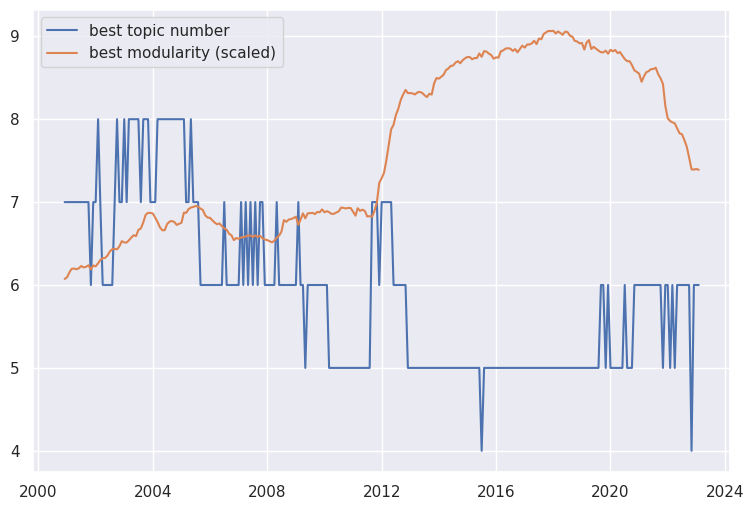

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(YYYYMM_list, res['size'], label='best topic number')
ax.plot(YYYYMM_list, np.array(res['mod'])*30 - 6, label='best modularity (scaled)')
ax.legend();

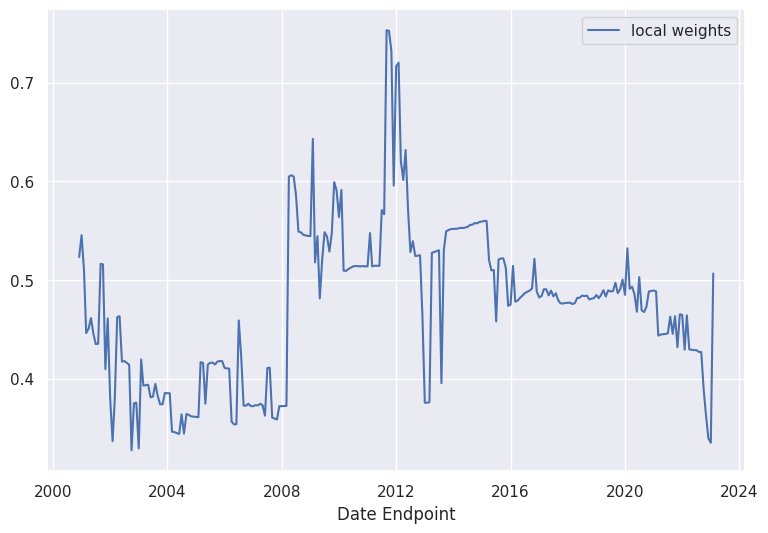

In [8]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(YYYYMM_list, cs_score_local_weights, label='local weights')
#ax.plot(YYYYMM_list, cs_score_global_weights, label='global weights')
ax.set_xlabel('Date Endpoint')
ax.legend();

Interpretations:
- global topic is heavily influenced by financial crisis
- geo-political events, e.g., Iraq around 2004, Ukraine around 2022
- least common words at low-similarity periods

- local weights for words
- store start date
- store dtm
- run and save topic allocations
- daily aggregation
- forecast regressions

# adjacent similarity

In [9]:
cs_list_local, cs_list_global = [], []
for i in range(len(topic_vec_local_weights)-1):
    cs_matrix = cosine_similarity(topic_vec_local_weights[i], topic_vec_local_weights[i+1])
    cs = np.fmax(get_matching_score(cs_matrix, 'max')[0], 0).mean()
    cs_list_local.append(cs)
    
    cs_matrix = cosine_similarity(topic_vec_global_weights[i], topic_vec_global_weights[i+1])
    cs = np.fmax(get_matching_score(cs_matrix, 'max')[0], 0).mean()
    cs_list_global.append(cs)

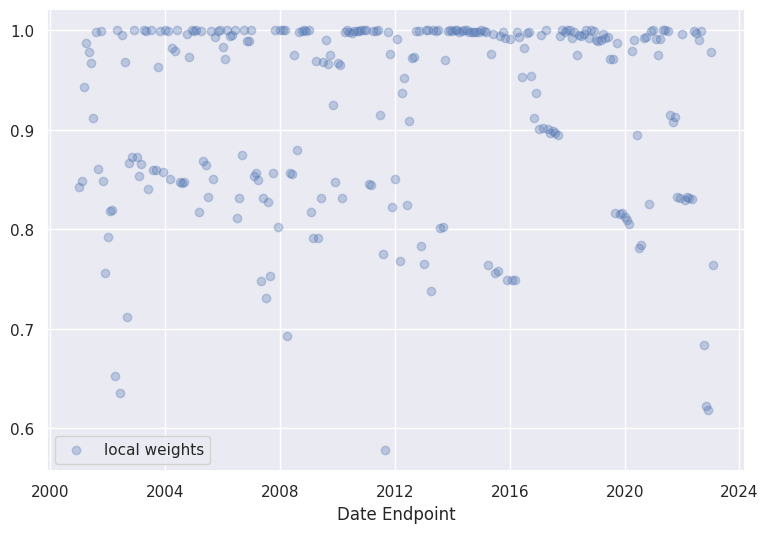

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(YYYYMM_list[1:], cs_list_local, alpha=0.3, label='local weights')
#ax.scatter(YYYYMM_list[1:], cs_list_global, alpha=0.3, label='global weights')
ax.set_xlabel('Date Endpoint')
ax.legend();

- k-means on all topics
- label meta-topics

In [11]:
topics = np.vstack(topic_vec_local_weights)

In [12]:
idx_list = []
for month, s in zip(YYYYMM_list, res['size']):
    idx_list.extend([str(month)[:10]]*s)
    
df = pd.DataFrame(topics, columns=m.columns)
df.index = idx_list
df.to_csv('topicVecs.csv')

In [14]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=15, n_init='auto')
# Fit the model
kmeans.fit(topics)
# Get cluster labels
labels = kmeans.labels_

In [15]:
labels.shape

(1578,)

In [16]:
tsne = TSNE(n_components=2, random_state=0)
# Perform dimensionality reduction
topics_tsne = tsne.fit_transform(topics)

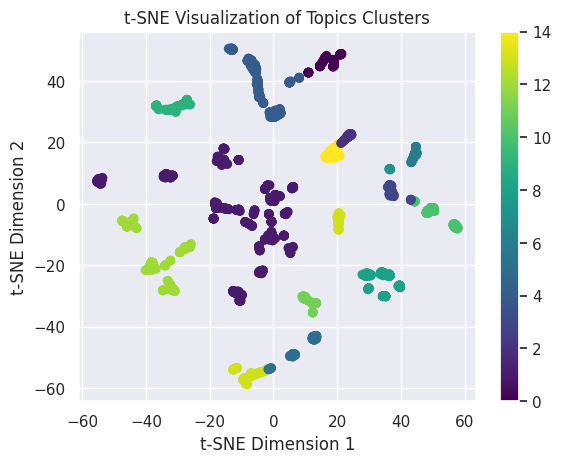

In [17]:
# Create a scatter plot
plt.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Topics Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

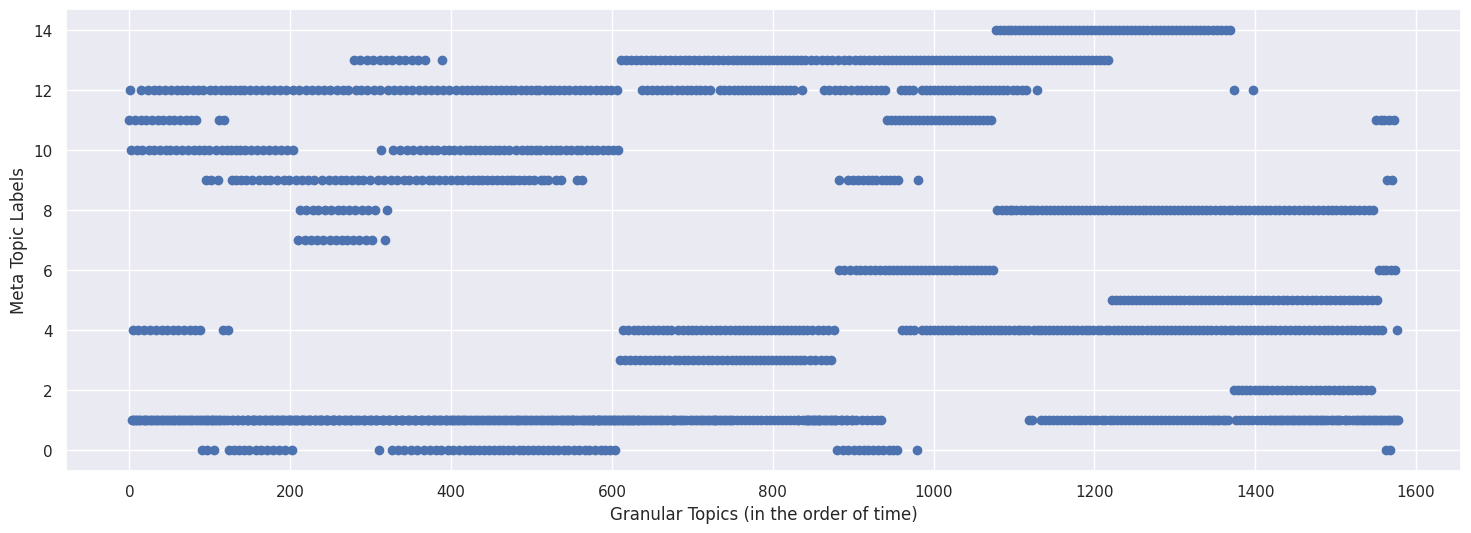

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
ax.scatter(range(len(labels)), labels)
ax.set_ylabel('Meta Topic Labels')
ax.set_xlabel('Granular Topics (in the order of time)');